# **OBJECT REMOVAL WITH SEAM CARVING ALGORITHM**

## Introduction

This project is an implementation of an object removal algorithm based on the seam carving content-aware resizing algorithm (the paper is available here: https://www.eng.tau.ac.il/~avidan/papers/imretFinal.pdf)


With only a few modifications from the original code, we will add a functionality that takes a binary mask as an input (with the object of interest) and a RGB image, and performs a content-aware resizing to eliminate the object. 

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir('/content/drive/My Drive/')

### Import libraries

In [ ]:
import numpy  as np
import matplotlib.pyplot as plt 
import cv2 

### Auxiliary functions

As an auxiliary function, we define normalize() as follows:

In [ ]:
def normalize(img):
  """
  Normalize a binary image into [0,1] range. 
    input: [h, w]: [0, 255]
    output: [h, w]: [0, 1]
  """
  img = (img - np.min(img)) / (np.max(img) - (np.min(img)))

  return img

## Seam carving algorithm

In this section we will follow the original implementation of the seam carving algorithm, taking into account the key operations that will need to be modified later on. The objective of seam carving is to eliminate the pixels that contain the **least information**. We will calculate the information as **the energy of the pixel**.

### Calculate energy map

In order to obtain the energy of an image, we only need a grayscale version of it. We filter the image with horizontal and vertical sobel filters, which return two borders-detected maps that can be combined to obtain the energy map.

In [ ]:
def energy_map(img):
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  sobel_horizontal = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0)
  sobel_vertical   = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1)
  
  energy = np.sqrt(np.power(sobel_horizontal, 2) + np.power(sobel_vertical, 2))
  energy = normalize(energy)
  
  return energy

### Calculate min energy path

This function calculated the accumulated cost map (row-wise) and stores it in a matrix M. The paths are obtained by marking the pixel with the lesser energy from the bottom row and tracing it back up to the first row following the minimum energy out of the top-right, top-center or top-left pixels every iteration.

In [ ]:
def seam_min(img):
    rows, cols, _ = img.shape
    energy = energy_map(img)
  
    M = np.zeros(shape=(rows, cols))  #M == Accumulated cost matrix
    P = np.zeros(shape=(rows, cols))
    
    M[0] = energy[0]
    P[0] = [-1] * cols 
    inf = float('Inf')

    for r in range(1, rows):
        for c in range(0, cols):
            option_1 = M[r - 1, c - 1] if (c > 0) else inf
            option_2 = M[r - 1, c] if (c < cols) else inf
            option_3 = M[r - 1, c + 1] if (c < cols - 1) else inf

            if (option_1 <= option_2 and option_1 <= option_3):
                M[r, c] = energy[r, c] + M[r - 1, c - 1]
                P[r, c] = c - 1
            elif (option_2 <= option_1 and option_2 <= option_3):
                M[r, c] = energy[r, c] + M[r - 1, c]
                P[r, c] = c
            else:
                M[r, c] = energy[r, c] + M[r - 1, c + 1]
                P[r, c] = c + 1

    P = P.astype(int)
    mask = np.ones((rows, cols), dtype=np.bool)
    j = np.argmin(M[-1])

    for i in reversed(range(rows)):
        mask[i, j] = False    #The path is marked as False
        j = P[i, j]
    mask = np.stack([mask] * 3, axis=2)
    
    return (M, P, mask)

### Eliminate column

This function reshapes the image by eliminating the calculated path. 

In [ ]:
def carve_seam(img):
  rows, cols, _ = img.shape
  M, P, mask = seam_min(img)
  
  img = img[mask].reshape((rows, cols - 1, 3))

  return img

### Resize

This function iterates the algorithm given a scale factor (between 0 and 1).

In [ ]:
def resize(img, factor):
  rows, cols, _ = img.shape
  new_cols= int(factor * cols)
  
  for i in range(cols - new_cols):
    img = carve_seam(img)
  
  return img

## Object removal

To implement the object removal functionality adjust Seam Carving to the required modifications.

The idea is to eliminate the object by altering the region of the energy map, so that the algorithm identifies that the minimum energy paths pass through the object. This region is defined by a binary mask we use as a parameter. In the energy map, we will set its pixels to negative values.

### Alter energy map

This funcion is essentially equal to the first energy_map(), but in this case we alter the energy in a given region (mask: objeto) to a negative value, so that, in the next step, its pixels are marked as seams of least energy.

In [ ]:
def energy_map_mask(img, objeto):
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  objeto = normalize(objeto)
  
   
  sobel_horizontal = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0)
  sobel_vertical   = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1)
  
  energy = np.sqrt(np.power(sobel_horizontal, 2) + np.power(sobel_vertical, 2))
  
  energy[objeto == 1] = -100 #Any value below 0 works just fine. 
  
  return energy

### Calculate min energy path

This function is not modified. We only include "objeto" as a parameter, which is required in energy_map_mask(). 

In [ ]:
def seam_min_mask(img, objeto):
 
    rows, cols, _ = img.shape
    ro, co = objeto.shape
    
    imagen = np.copy(img)
        
    energy = energy_map_mask(imagen, objeto)
    
    M = np.zeros(shape=(rows, cols))
    P = np.zeros(shape=(rows, cols))
    
    M[0] = energy[0]
    P[0] = [-1] * cols 
    inf = float('Inf')

    for r in range(1, rows):
        for c in range(0, cols):
            option_1 = M[r - 1, c - 1] if (c > 0) else inf
            option_2 = M[r - 1, c] if (c < cols) else inf
            option_3 = M[r - 1, c + 1] if (c < cols - 1) else inf

            if (option_1 <= option_2 and option_1 <= option_3):
                M[r, c] = energy[r, c] + M[r - 1, c - 1]
                P[r, c] = c - 1
            elif (option_2 <= option_1 and option_2 <= option_3):
                M[r, c] = energy[r, c] + M[r - 1, c]
                P[r, c] = c
            else:
                M[r, c] = energy[r, c] + M[r - 1, c + 1]
                P[r, c] = c + 1

    P = P.astype(int)
        
    mask = np.ones((rows, cols), dtype=np.bool)

    j = np.argmin(M[-1])

    for i in reversed(range(rows)):
        mask[i, j] = False
        j = P[i, j]

    mask = np.stack([mask] * 3, axis=2)
    
    return M, P, mask

### Eliminate column

We now eliminate the marked seam, both in the image and in our binary mask, so that they always have the same resolution during the loop. 

In [ ]:
def carve_seam_mask(img, objeto):
  rows, cols, _ = img.shape
  
  M, P, mask = seam_min_mask(img, objeto)
  
  img = img[mask].reshape((rows, cols - 1, 3))  #Image
  
  maskObjeto = mask[:,:,0]
  objeto = objeto[maskObjeto].reshape((rows, cols -1)) #Object mask 

  return img, objeto

### Resize

Instead of resizing by a scale factor, we now want to resize a certain amount of columns that will depend on the size of the object. In order to calculate the width of the object, we sum the columns of the binary mask and return the min/max values which are not 0. The difference between these two values is the number of iterations the algorithm needs to take. 

In [ ]:
def resize_mask(img, objeto):
  rows, cols, _ = img.shape
  
  suma = objeto.sum(axis=0)
  minMask = np.min(np.where(suma != 0))
  maxMask = np.max(np.where(suma != 0))
  
  diff = (maxMask - minMask)
  
  
  for i in range(diff):
    img, objeto = carve_seam_mask(img, objeto)
    
  return img

## TEST

We tested the implementation with a basic scenario. In the following picture we can see the original image (imagen original), the object mask (máscara de objeto a eliminar), the energy map (energía original), the modified energy map (energía modificada), the M matrix (matriz M original), the modified M matrix (matriz M modificada), the marked seam (seam calculado) and the resized image (seam eliminado). 

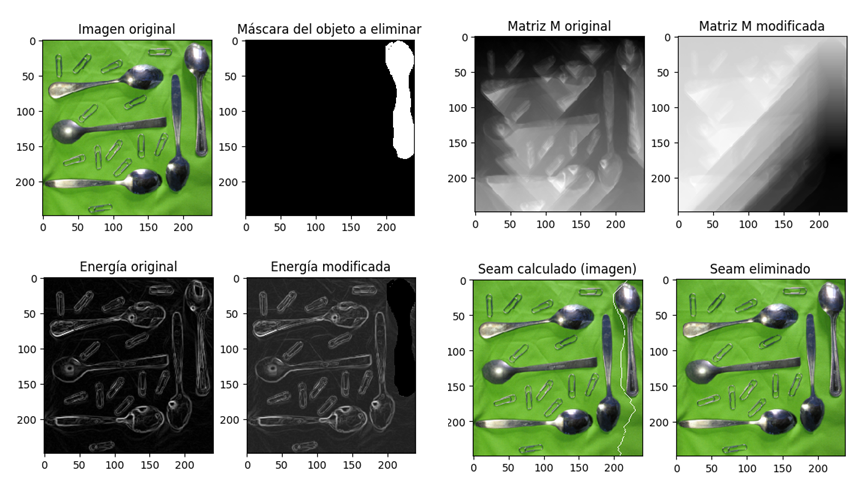

The result is this image:

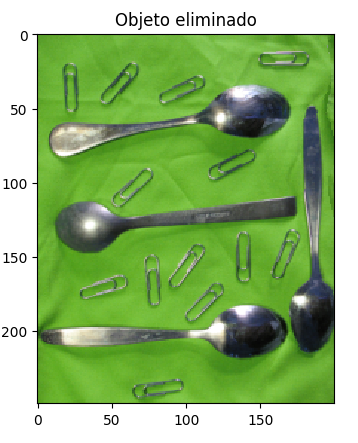